In [62]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
from scipy import stats
from scipy.spatial import ConvexHull
import pylustrator
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.decomposition import PCA

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

In [63]:
def find_cov_matrix(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'covariance_matrix.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'covariance_matrix.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths


all_cov_paths = find_cov_matrix(os.path.join(ROOT_DIR, "results", "case-studies"))
all_cov_dfs = []




for path in all_cov_paths:
    if 'scaleTesting' in path:
        continue
    cov_master_df = pd.DataFrame(columns=['dataset', 'transform', 'subset', 'channel', 'orientation', 'dataset_type'], index=[0])

    parts = Path(path).parts[-7:]
    if parts[0] == 'case-studies':
        parts = parts[1:]
    elif parts[0] == 'results':
        parts = parts[2:]
    if "MRI" in path:
        dataset, slice, transform, orientation, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = slice
        cov_master_df['channel'] = np.nan
        cov_master_df['orientation'] = orientation
       
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = subset
        cov_master_df['channel'] = channel
        cov_master_df['orientation'] = orientation
       
    elif "learned" in path:
        dataset, subset, transform, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = subset
        cov_master_df = cov_master_df.rename(columns={'filter_group' : 'orientation'})
        cov_master_df['channel'] = np.nan
       

    else:
        dataset, size, transform, channel, _, _ = parts
        
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = size
        cov_master_df['channel'] = channel
        cov_master_df['orientation'] = np.nan
       
    
    if dataset in ['pastis', 'agriVision', 'spaceNet']:
        cov_master_df['dataset_type'] = 'remote sensing'
    elif dataset in ['syntheticMRI2D', 'syntheticMRI3D']:
        cov_master_df['dataset_type'] = 'medical'
    elif dataset in ['coco', 'segmentAnything', 'standardTesting']:
        cov_master_df['dataset_type'] = 'natural'
    # elif dataset in ['standardTesting']:
    #     master_df['dataset_type'] = 'classical'
    cov_matrix = pd.read_csv(path[:-26] + "CSVs" + os.sep + "covariance_matrix.csv").drop(columns=['Unnamed: 0'], axis = 1).to_numpy()
    cov_master_df["fro_norm"] = np.linalg.norm(cov_matrix - np.diag(np.diag(cov_matrix)))/group_num**2
    cov_master_df["rel_fro_norm"] = np.linalg.norm(cov_matrix - np.diag(np.diag(cov_matrix))) / np.linalg.trace(cov_matrix)
    pca = PCA()
    pca.fit(cov_matrix)
    eigenvectors = pca.components_
    group_num = eigenvectors.shape[0]
    cos_dist = distance.cdist(eigenvectors, np.eye(group_num), metric='cosine')
    min_cos_dist = [np.min(row) for row in cos_dist.T]
    arg_min_cos_dist = [np.argmin(row) for row in cos_dist.T]
    cov_master_df["cov_matrix"] = [cov_matrix]
    cov_master_df["pca_comp"] = [arg_min_cos_dist]
    cov_master_df["cosine_dist"] = [min_cos_dist]
    cov_master_df["num_groups"] = group_num
    all_cov_dfs.append(cov_master_df)
    
cov_main_df = pd.concat(all_cov_dfs)


In [64]:
cov_main_df["max_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.max(x))

cov_main_df["median_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.median(x))
cov_main_df["75_percent_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.percentile(x, 75))
cov_main_df["90_percent_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.percentile(x, 90))


In [65]:
cov_main_df["pca_val_max_cosine_dist"] = cov_main_df.apply(
    lambda row: row["pca_comp"][np.argmax(row["cosine_dist"])], axis=1
)

In [ ]:
cov_main_df.sort_values(by=["max_cosine_dist"], ascending=False)

In [73]:
pd.set_option('display.max_rows', None)
cov_main_df.sort_values(by=["pca_val_max_cosine_dist"], ascending=True)


,dataset,transform,subset,channel,orientation,dataset_type,fro_norm,rel_fro_norm,cov_matrix,pca_comp,cosine_dist,num_groups,max_cosine_dist,median_cosine_dist,75_percent_cosine_dist,90_percent_cosine_dist,pca_val_max_cosine_dist
0,syntheticMRI3D,wavelet,full,NaN,ada,medical,6.336197,0.000031,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 11...","[6, 0, 1, 2, 3, 4, 5]","[0.0, 0.002342357048039423, 0.0036152536224066...",7,0.003615,0.001084,0.002208,0.002852,1
0,syntheticMRI2D,wavelet,coronal,NaN,vertical,medical,3.156751,0.000021,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[7, 0, 1, 2, 3, 4, 5, 6]","[0.0, 0.001738508193167787, 0.0026558641094497...",8,0.002656,0.001371,0.002191,0.002500,1
0,syntheticMRI2D,wavelet,coronal,NaN,diagonal,medical,0.467184,0.000019,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[7, 1, 0, 2, 3, 4, 5, 6]","[0.0, 0.021967403638165295, 0.0202113158936781...",8,0.021967,0.001153,0.008589,0.020738,1
0,syntheticMRI2D,wavelet,sagittal,NaN,vertical,medical,0.571770,0.000012,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[7, 1, 0, 2, 3, 4, 5, 6]","[0.0, 0.16019823626937624, 0.1582758905584808,...",8,0.160198,0.003398,0.043864,0.158853,1
0,syntheticMRI2D,wavelet,sagittal,NaN,diagonal,medical,0.343567,0.000007,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[7, 0, 1, 2, 3, 4, 5, 6]","[0.0, 0.006505125379289267, 0.0068692189280310...",8,0.006869,0.001670,0.003749,0.006614,1
0,syntheticMRI3D,wavelet,full,NaN,dda,medical,3.499590,0.000032,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 29...","[6, 0, 1, 2, 3, 4, 5]","[0.0, 0.01925827014963999, 0.02003666164976891...",7,0.020037,0.000558,0.010508,0.019570,1
0,syntheticMRI2D,wavelet,coronal,NaN,horizontal,medical,1.283155,0.000024,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[7, 1, 0, 2, 3, 4, 5, 6]","[0.0, 0.025596532653324955, 0.0233733738827247...",8,0.025597,0.001915,0.009884,0.024040,1
0,syntheticMRI3D,wavelet,full,NaN,add,medical,6.679190,0.000035,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 50...","[6, 0, 1, 2, 3, 4, 5]","[0.0, 0.029949851197167865, 0.0300894657160309...",7,0.030089,0.000788,0.015426,0.030006,1
0,syntheticMRI3D,wavelet,full,NaN,daa,medical,8.416515,0.000032,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 69...","[6, 0, 1, 2, 3, 4, 5]","[0.0, 0.018157857292413926, 0.0198472752560652...",7,0.019847,0.001086,0.010815,0.018834,1
0,syntheticMRI3D,wavelet,full,NaN,ddd,medical,2.687171,0.000032,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 27...","[6, 0, 1, 2, 3, 4, 5]","[0.0, 0.004121264191886298, 0.0043550671533029...",7,0.004355,0.000757,0.002542,0.004215,1


In [67]:
pd.reset_option('display.max_rows')

In [68]:
cov_main_df.sort_values(by = ["fro_norm"], ascending=True)

,dataset,transform,subset,channel,orientation,dataset_type,fro_norm,rel_fro_norm,cov_matrix,pca_comp,cosine_dist,num_groups,max_cosine_dist,median_cosine_dist,75_percent_cosine_dist,90_percent_cosine_dist,pca_val_max_cosine_dist
0,pastis,fourier,full,green,NaN,remote sensing,0.000038,0.000030,"[[321.53044224574114, -0.0184623479832124, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.002300951724109046, 0.0066573423500302376, ...",32,0.046586,0.017354,0.024148,0.028525,30
0,pastis,fourier,full,red,NaN,remote sensing,0.000042,0.000030,"[[307.1696393694636, -0.0170876372812473, 0.00...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0022258367657147504, 0.006086634490711673, ...",32,0.048598,0.017280,0.026265,0.032267,30
0,pastis,fourier,full,gray,NaN,remote sensing,0.000045,0.000030,"[[324.3041144967889, -0.0185620355914687, 0.00...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0022427023937773294, 0.006348720949019393, ...",32,0.039165,0.016603,0.021815,0.024772,30
0,coco,wavelet,outdoor,green,horizontal,natural,0.000062,0.000004,"[[57442.61057096408, -0.0966917586613482, -0.0...","[0, 1, 2, 3, 4, 5, 6, 7]","[0.00038887219997640887, 0.0008196838219430846...",8,0.011860,0.001803,0.005481,0.009927,6
0,pastis,fourier,full,blue,NaN,remote sensing,0.000063,0.000031,"[[466.0599749975096, -0.0267702283814654, 0.00...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.00218458363535734, 0.00588603992922021, 0.0...",32,0.046664,0.015095,0.021746,0.027145,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,syntheticMRI2D,wavelet,axial,NaN,horizontal,medical,6.656026,0.000033,"[[1134723.8088481815, 7.85073979698548, -73.88...","[2, 0, 1, 3, 4, 5, 6, 7]","[0.01195404167368952, 0.006265384902118032, 0....",8,0.013456,0.006716,0.010116,0.012405,3
0,syntheticMRI3D,wavelet,full,NaN,add,medical,6.679190,0.000035,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 50...","[6, 0, 1, 2, 3, 4, 5]","[0.0, 0.029949851197167865, 0.0300894657160309...",7,0.030089,0.000788,0.015426,0.030006,1
0,syntheticMRI3D,wavelet,full,NaN,daa,medical,8.416515,0.000032,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 69...","[6, 0, 1, 2, 3, 4, 5]","[0.0, 0.018157857292413926, 0.0198472752560652...",7,0.019847,0.001086,0.010815,0.018834,1
0,syntheticMRI2D,wavelet,axial,NaN,vertical,medical,18.597226,0.000004,"[[281123559.7199261, 245.590190363222, -734.69...","[0, 1, 2, 3, 4, 5, 6, 7]","[3.0824154230280065e-05, 0.0001137230590643190...",8,0.009082,0.001872,0.005210,0.007361,3


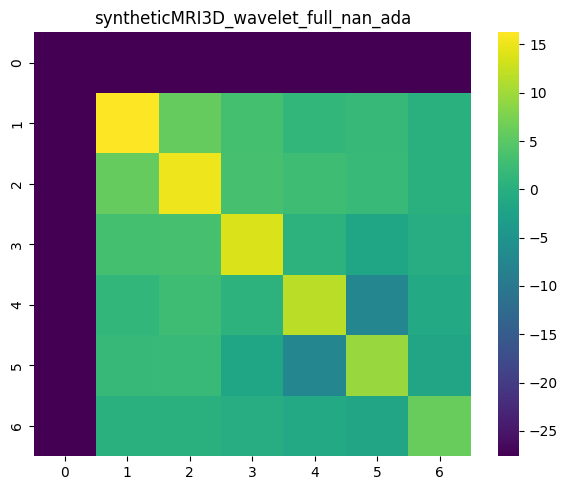

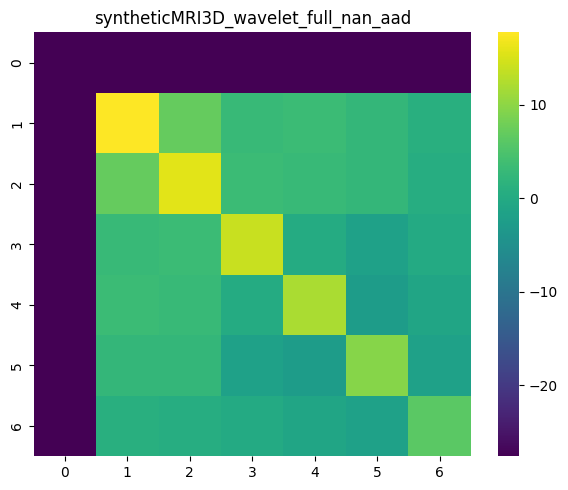

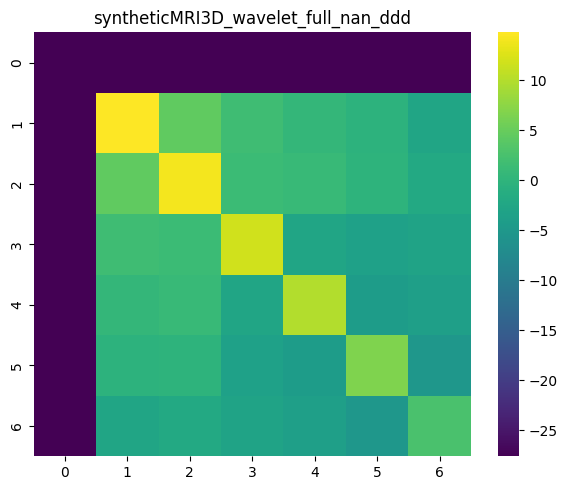

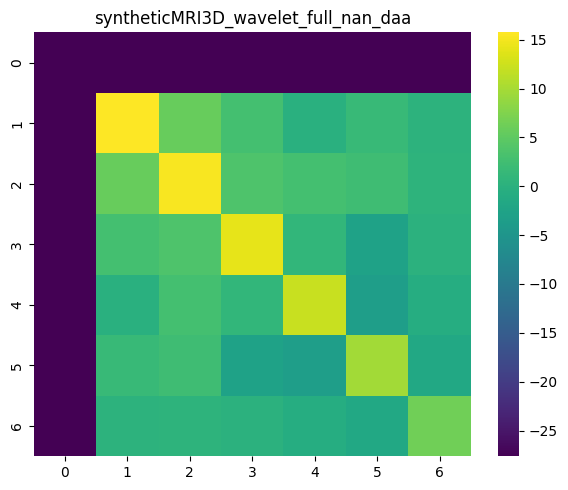

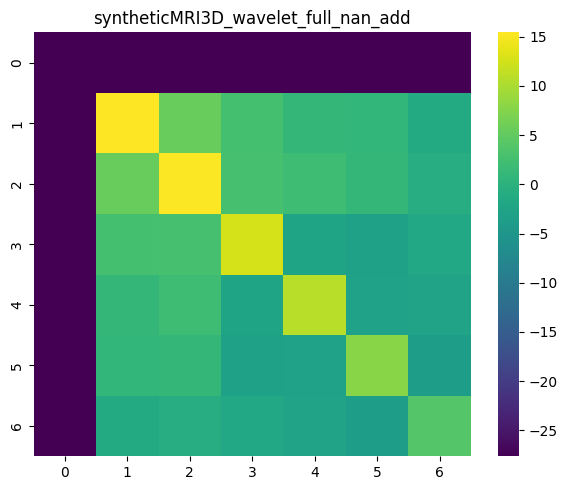

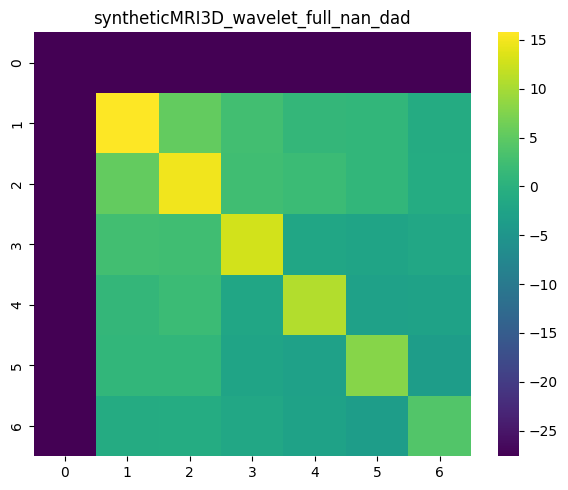

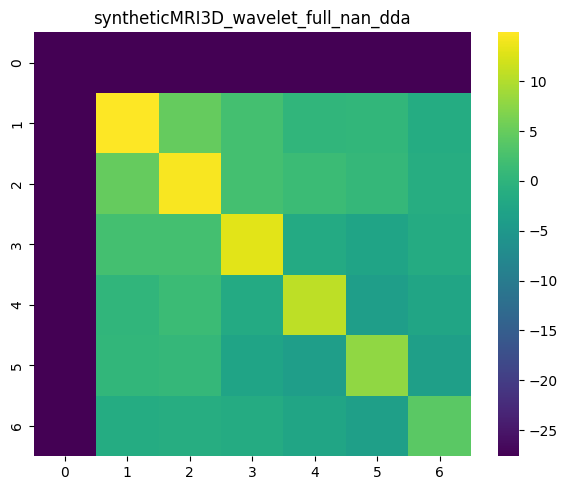

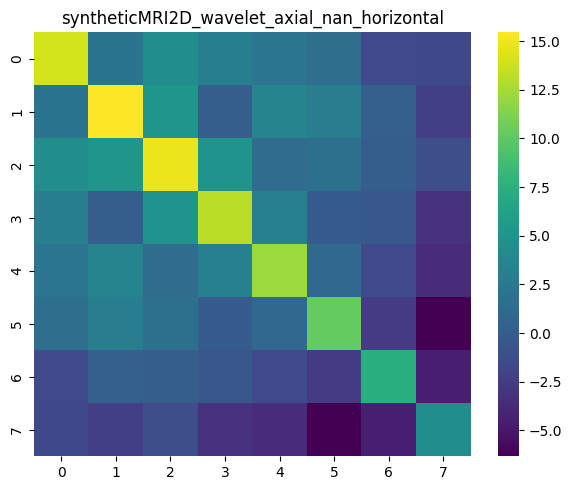

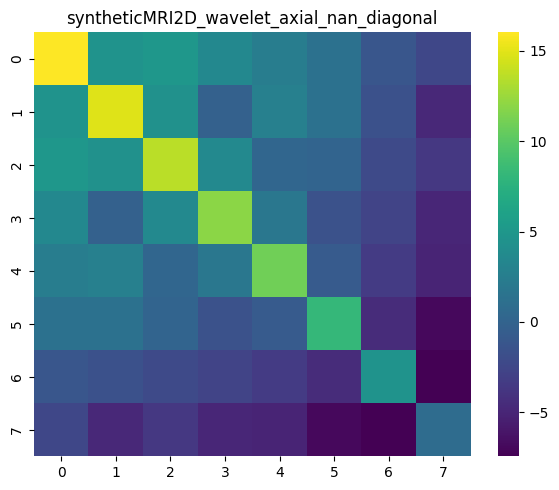

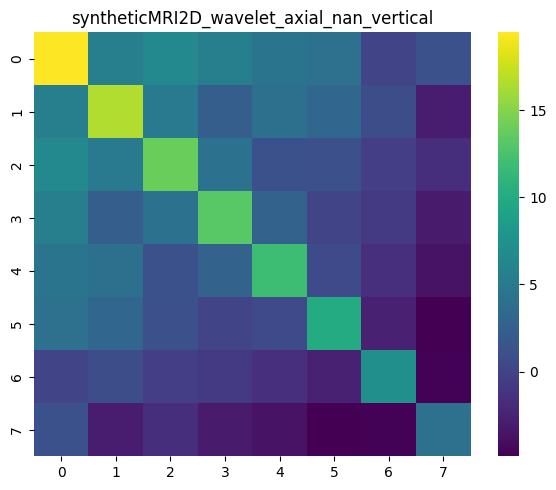

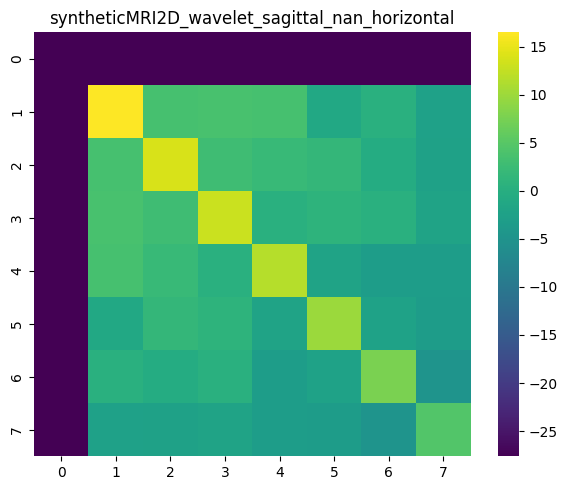

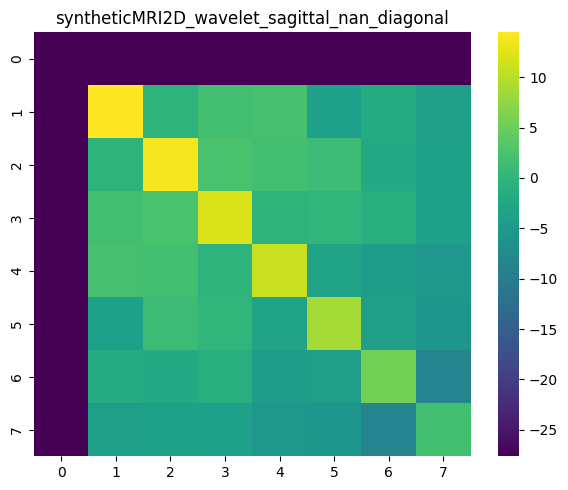

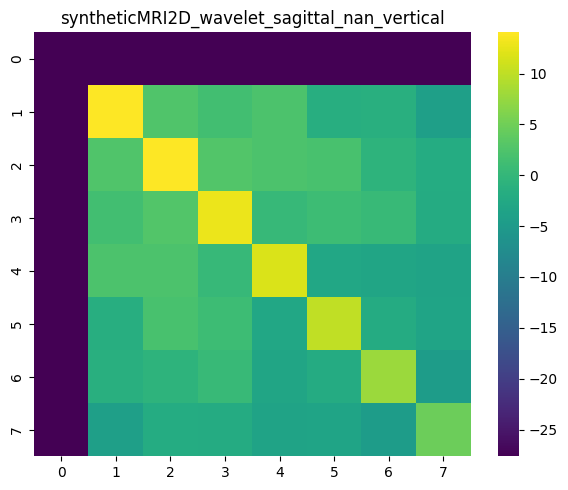

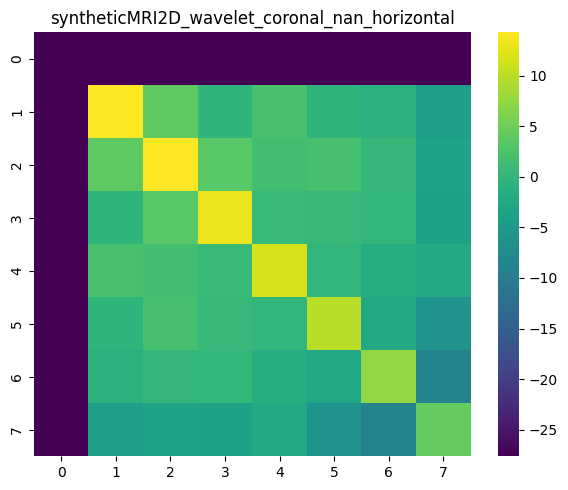

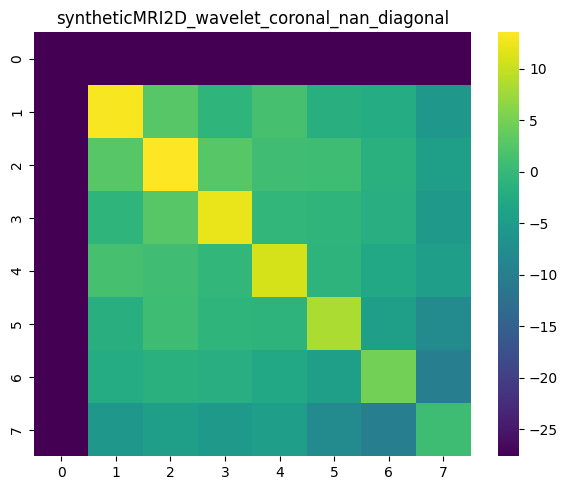

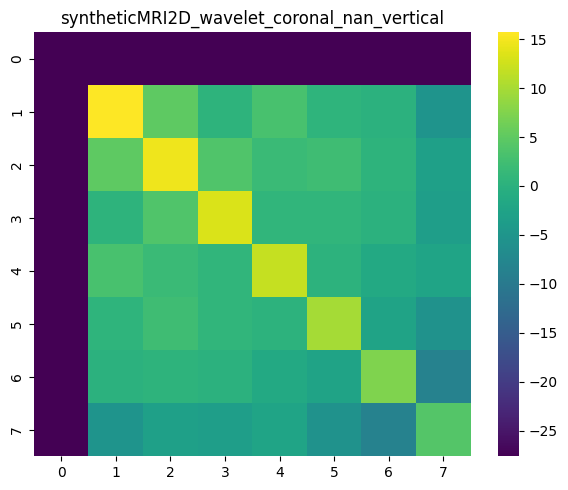

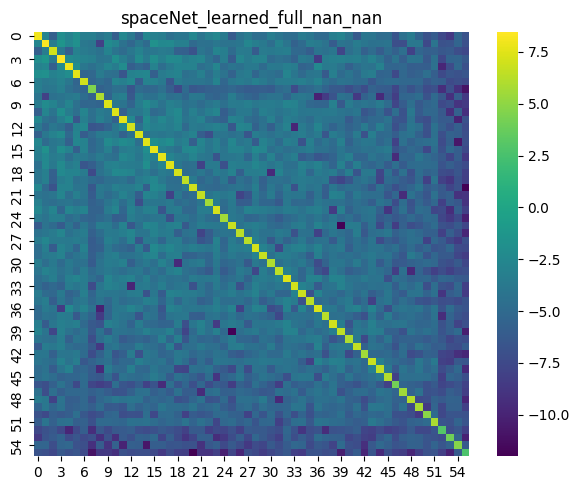

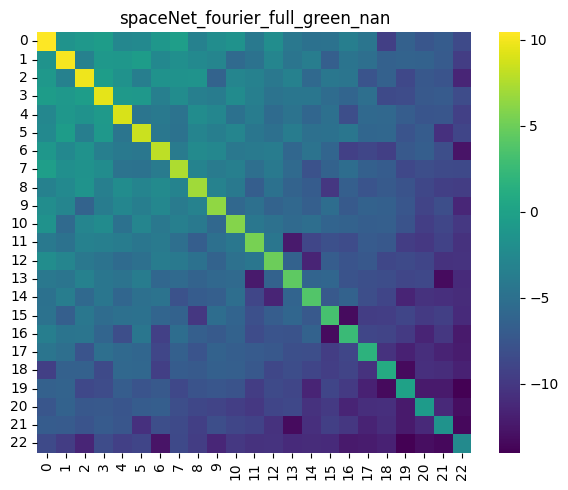

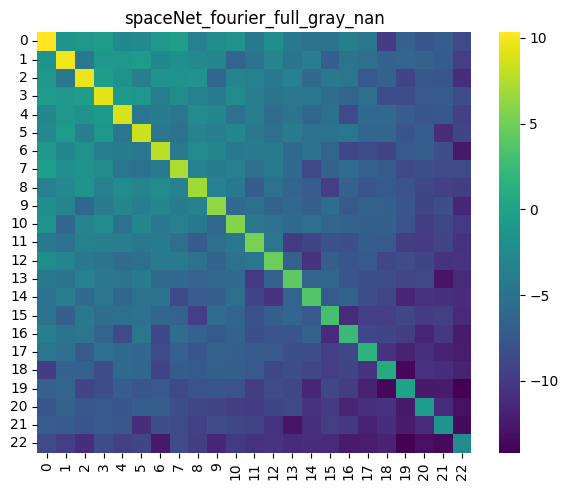

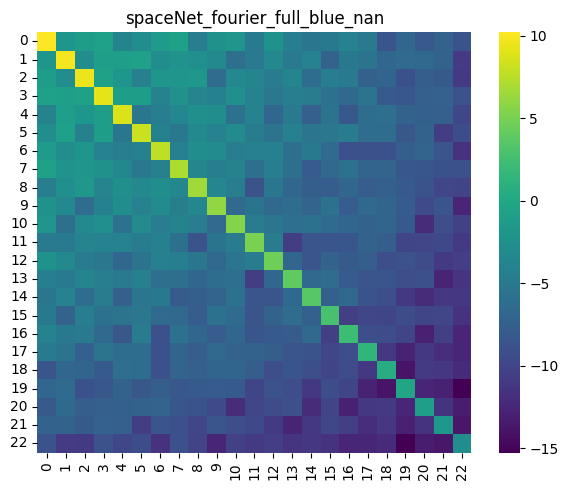

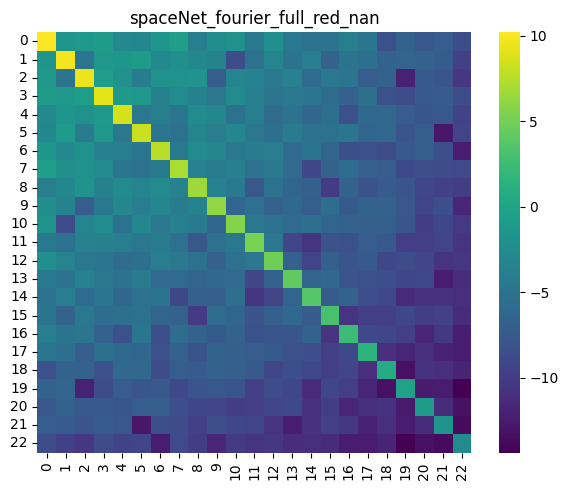

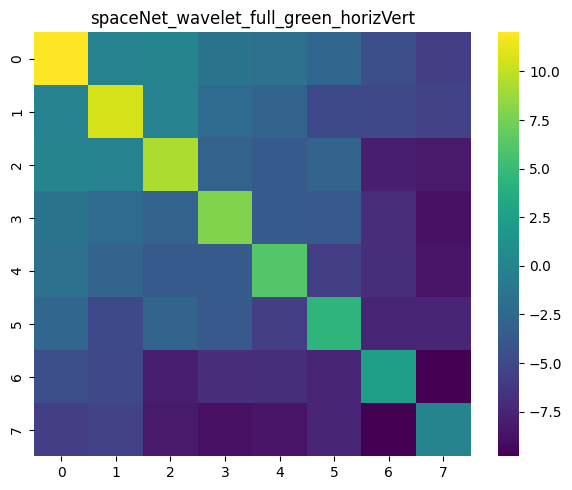

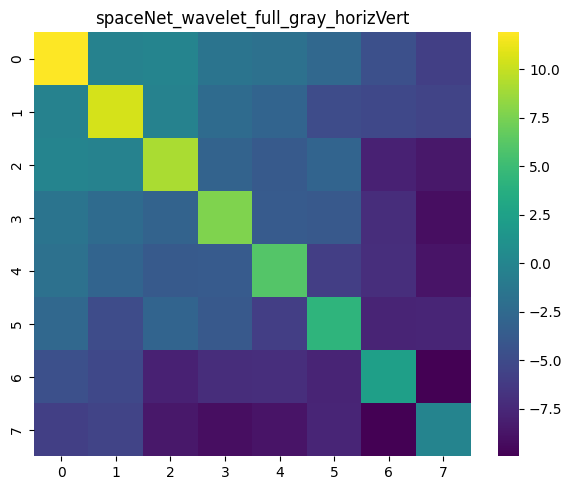

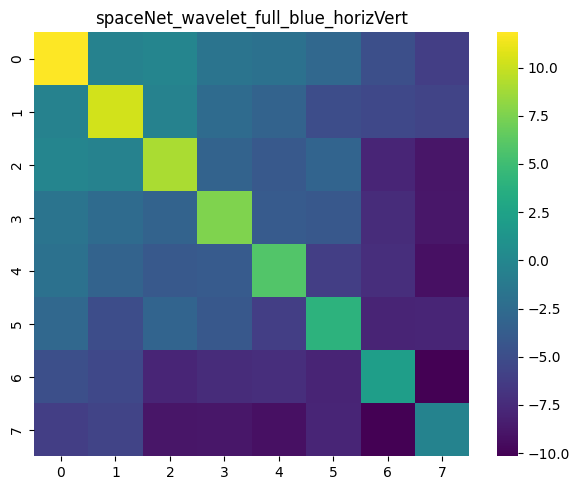

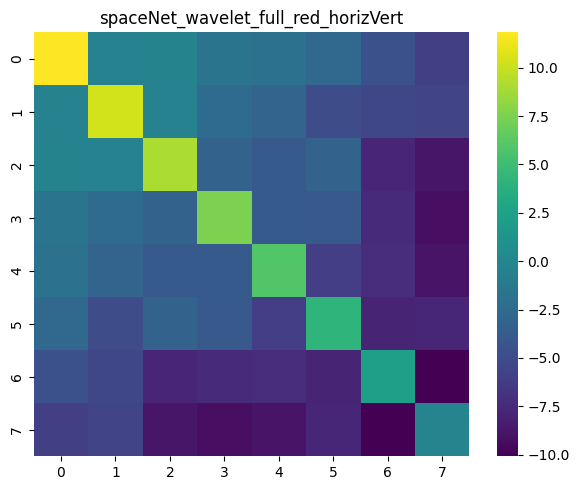

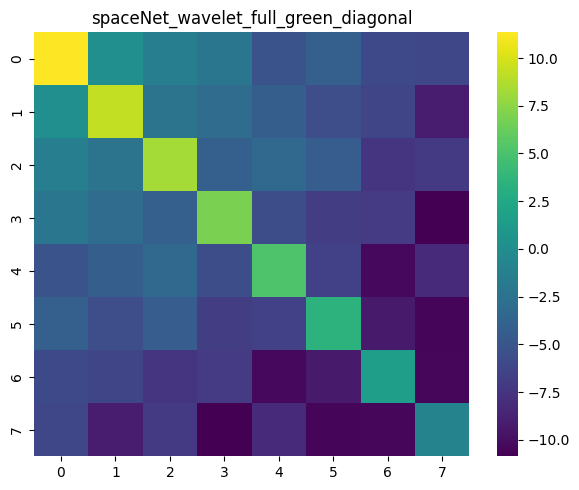

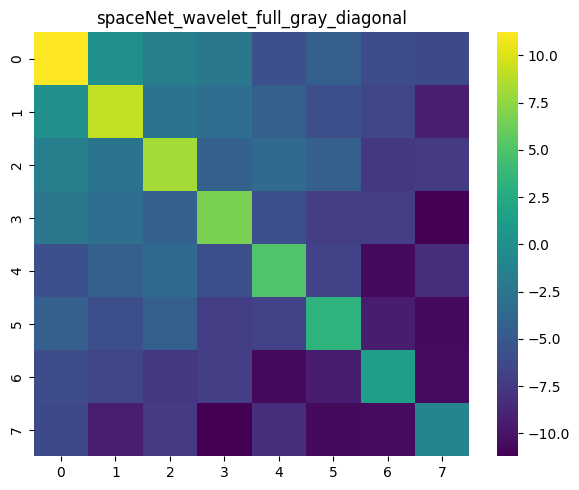

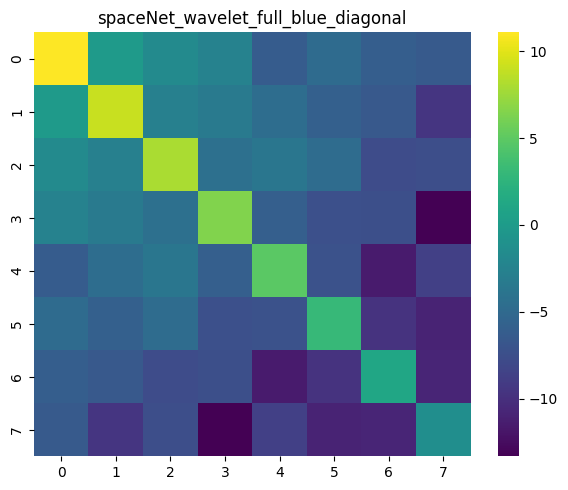

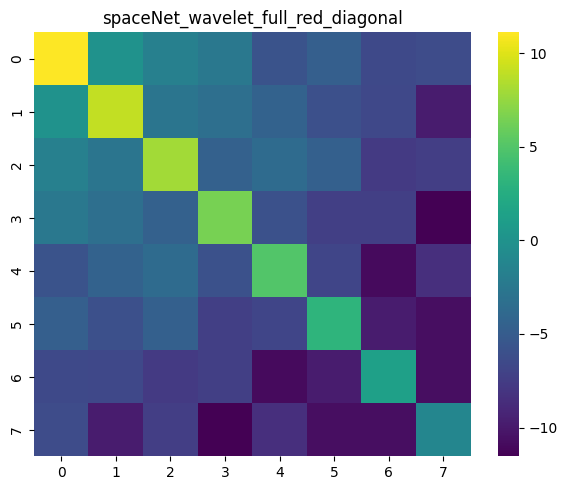

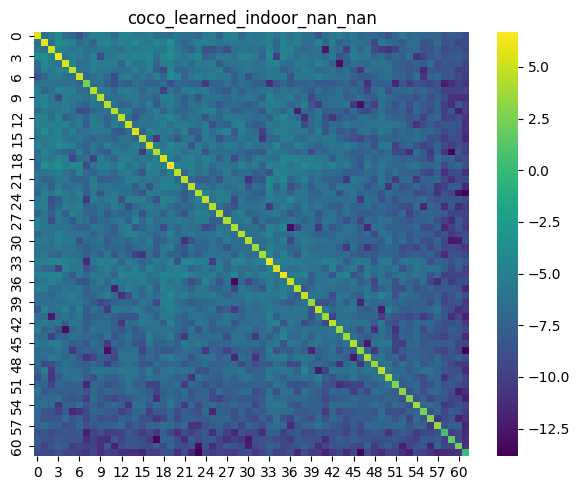

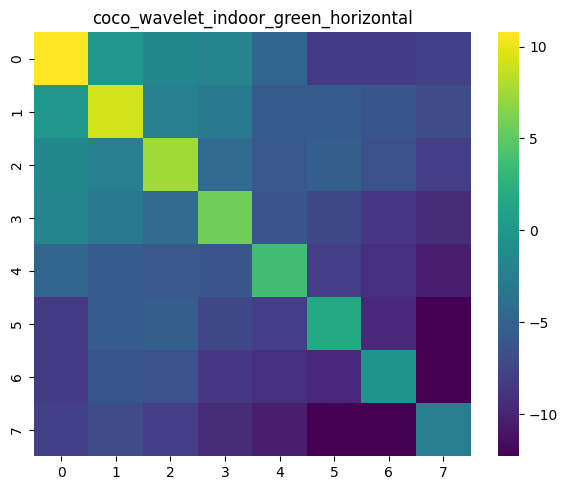

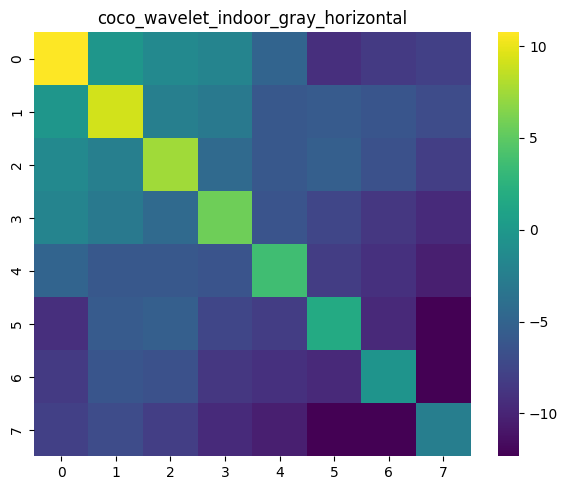

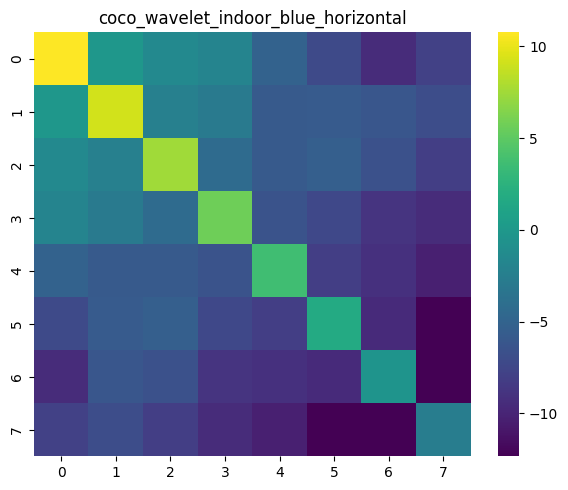

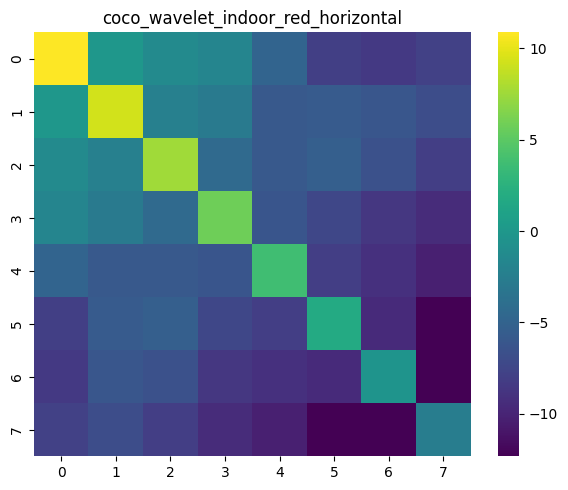

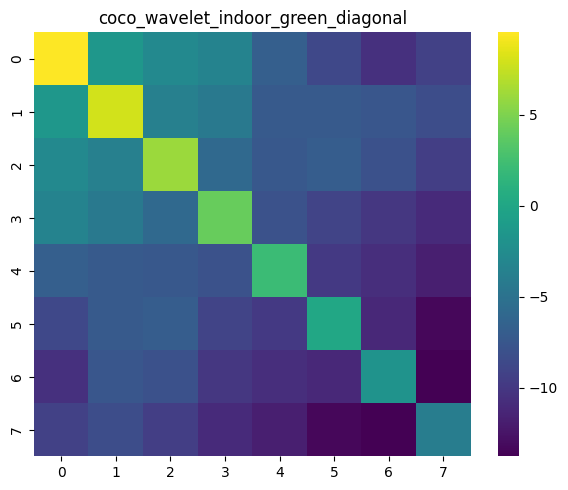

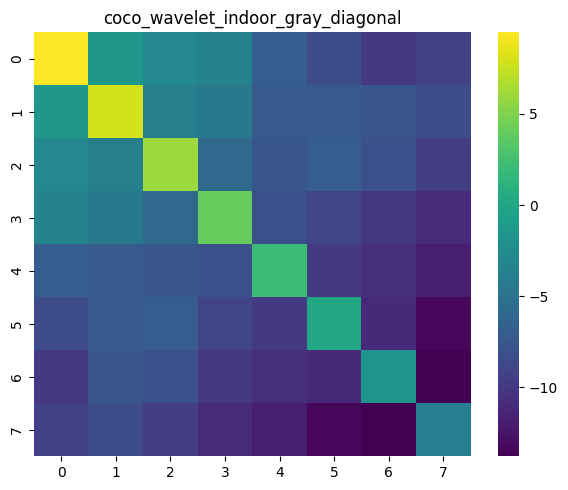

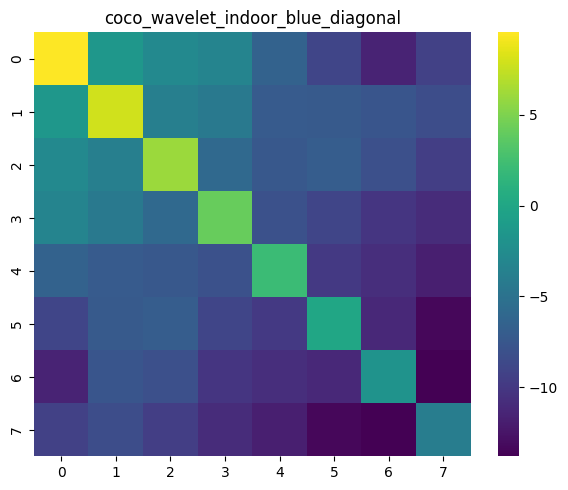

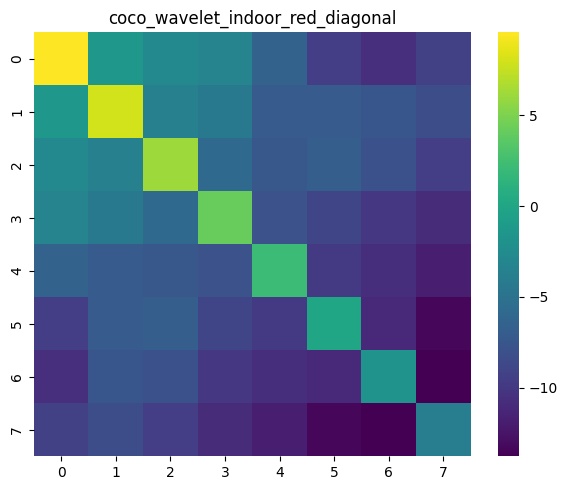

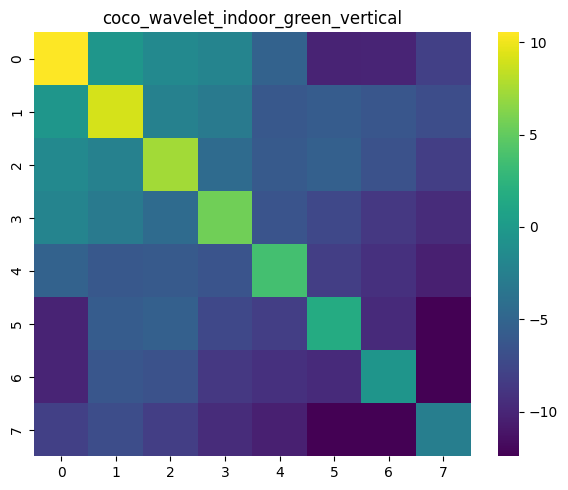

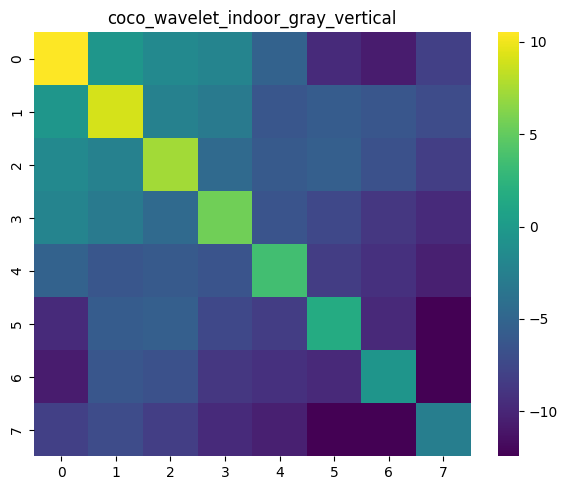

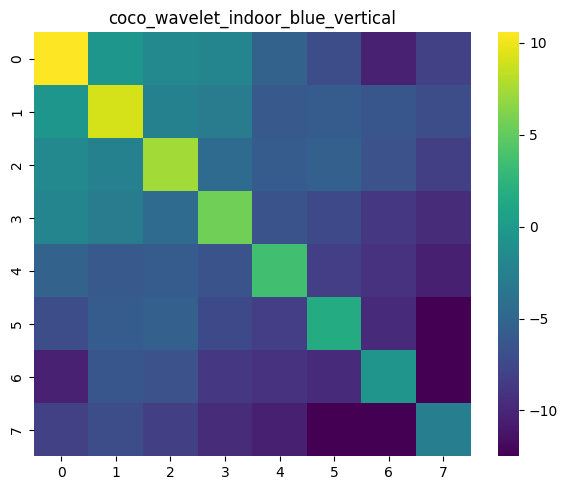

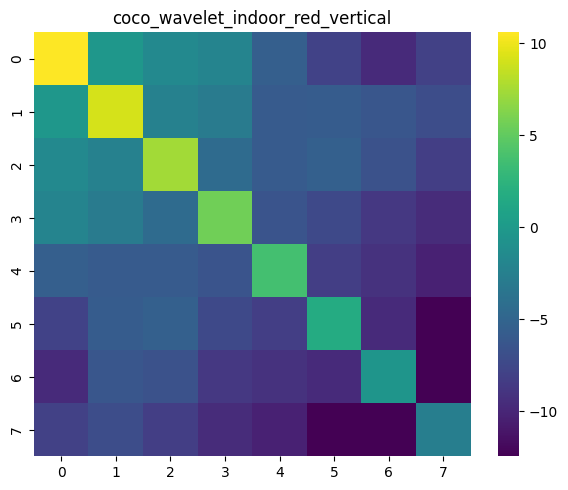

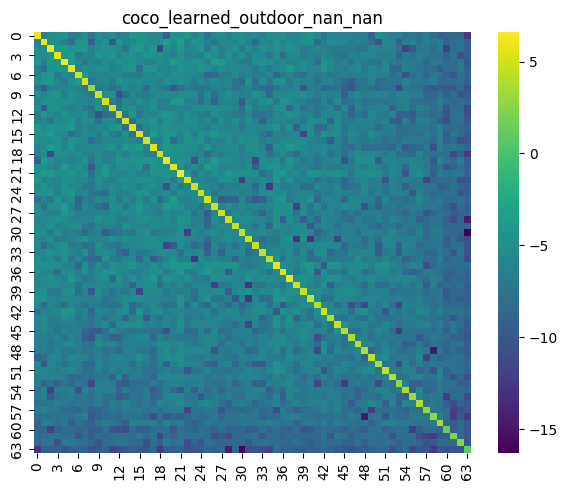

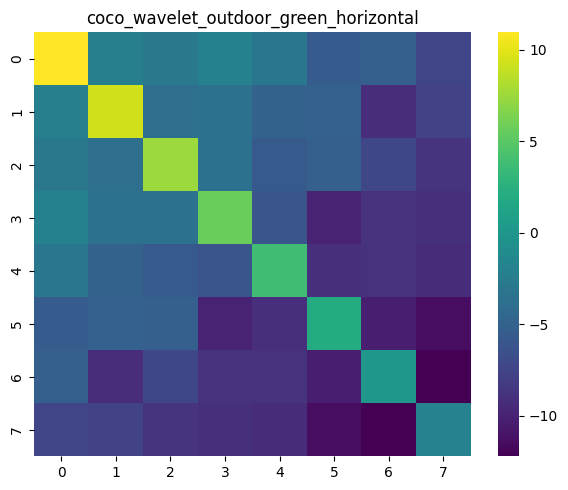

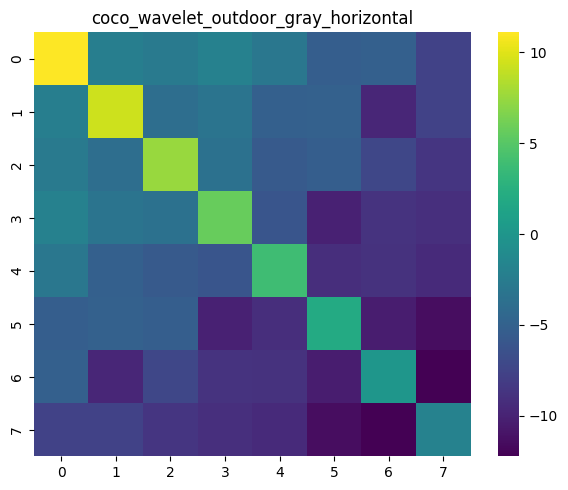

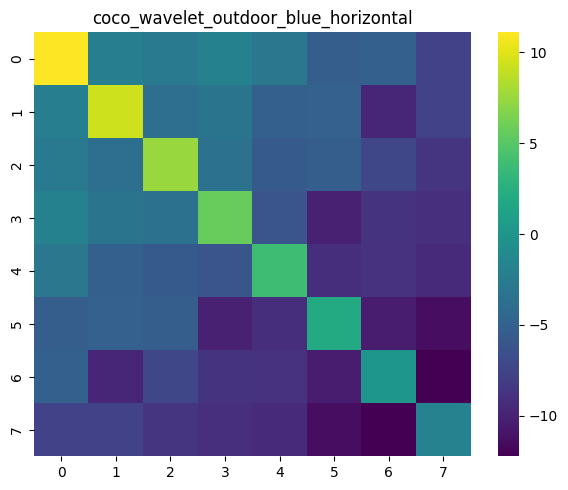

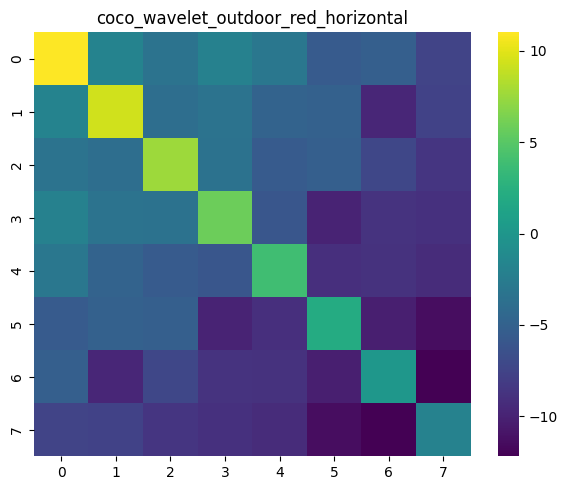

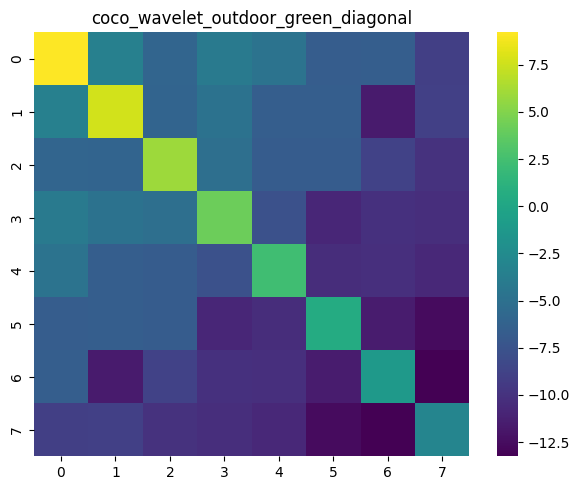

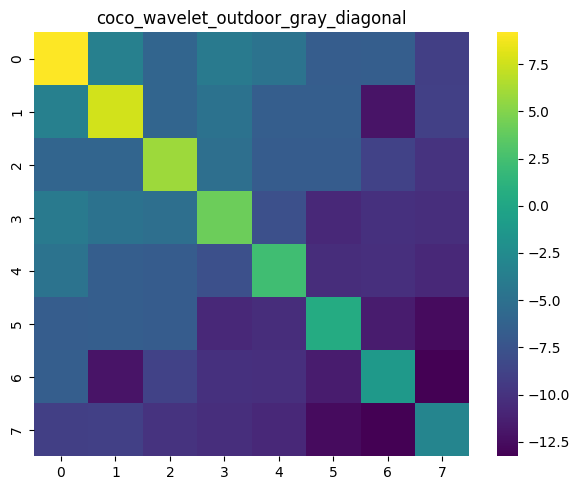

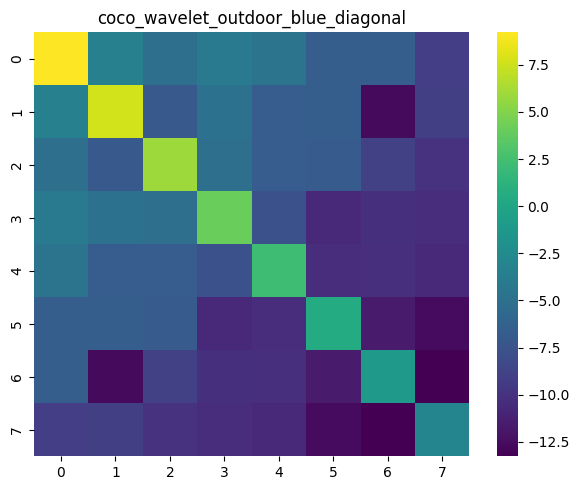

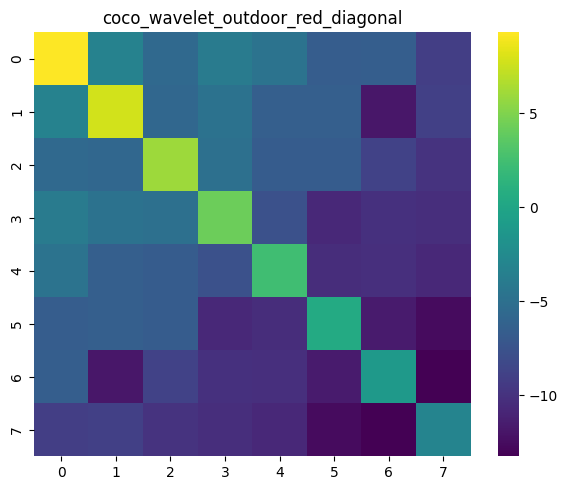

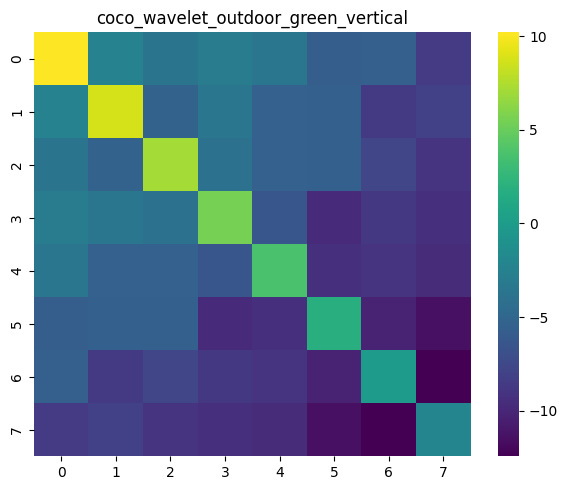

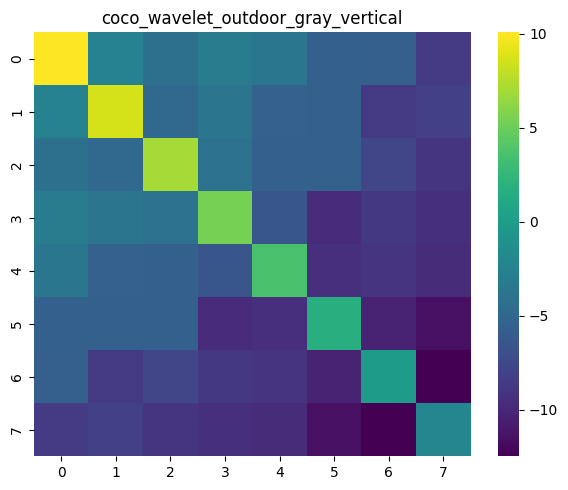

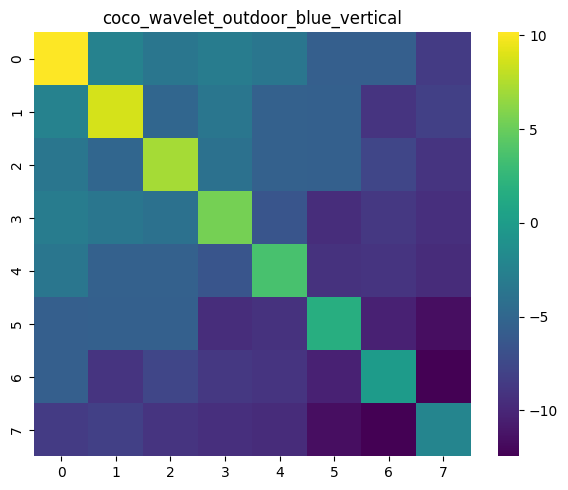

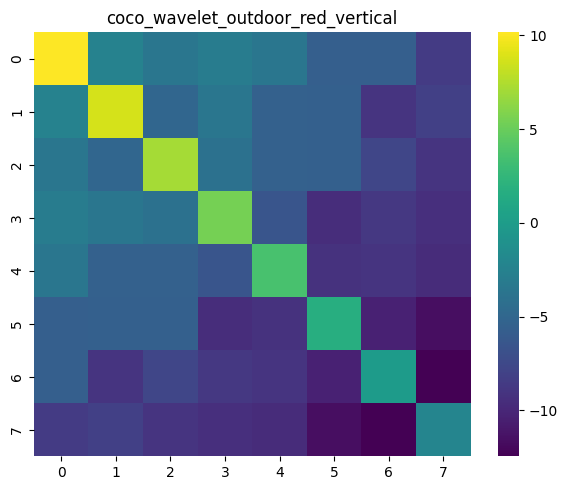

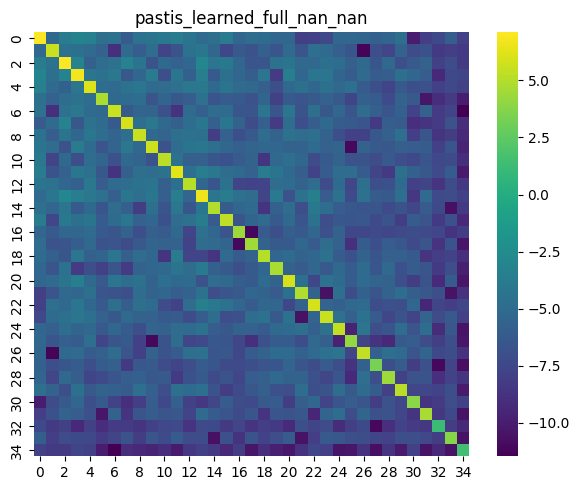

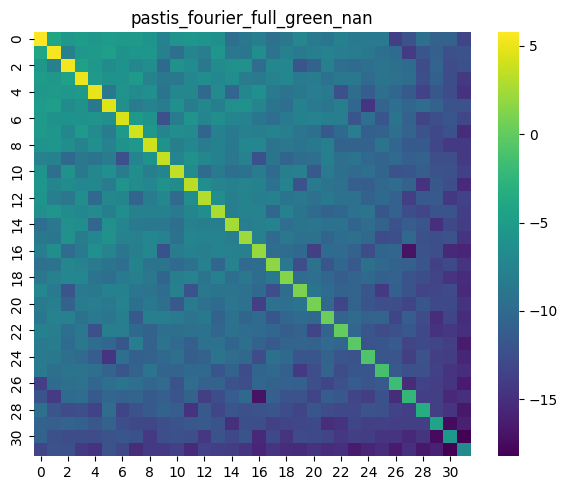

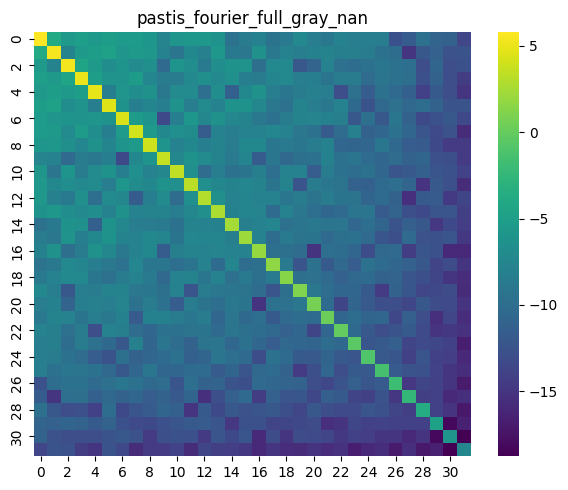

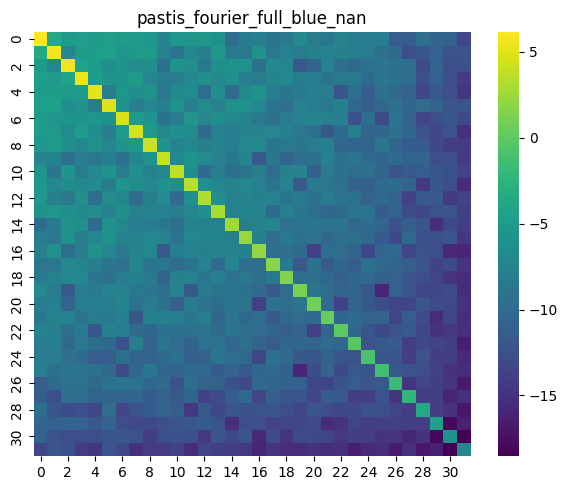

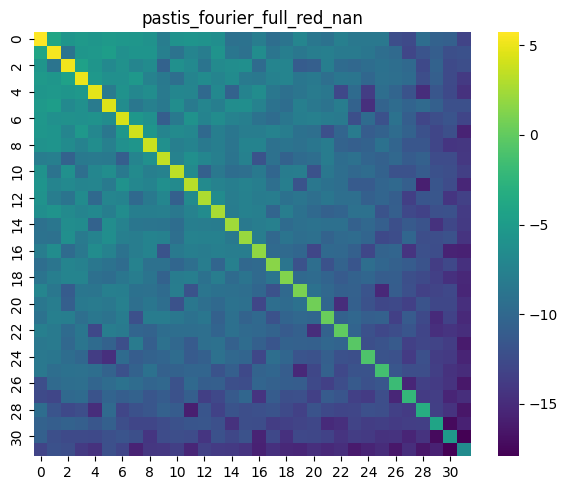

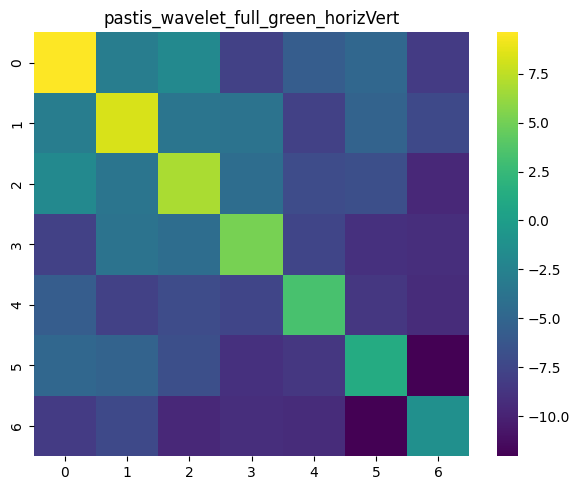

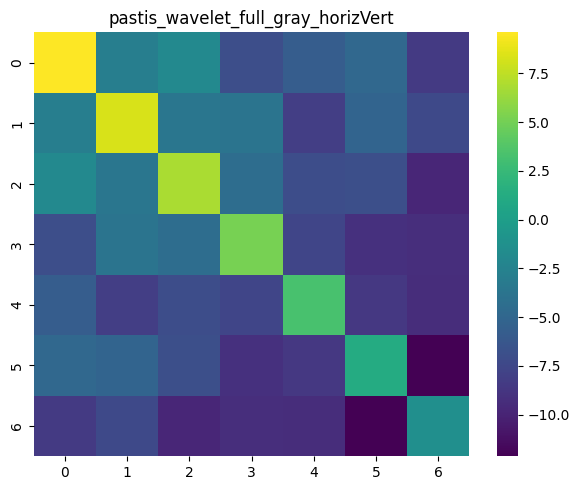

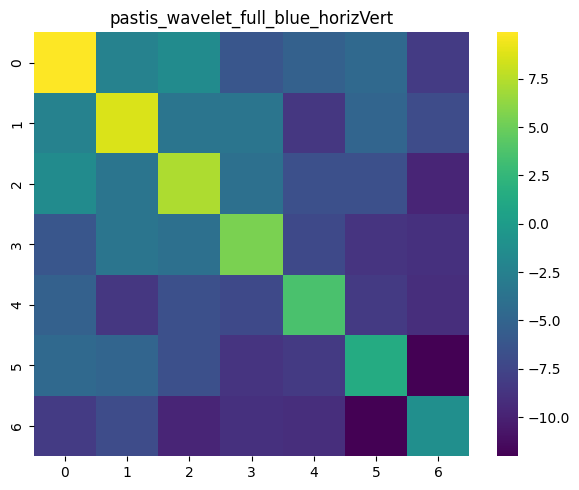

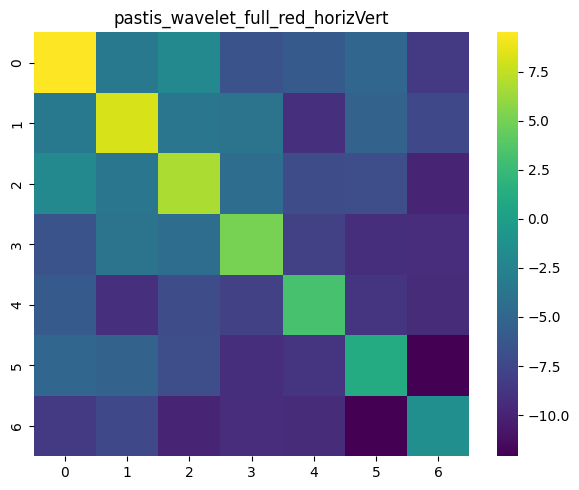

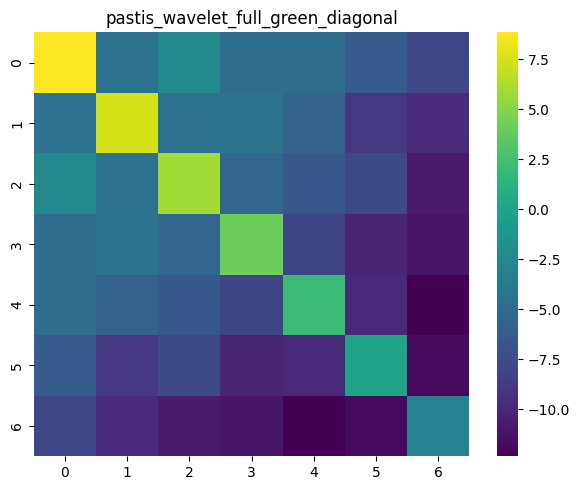

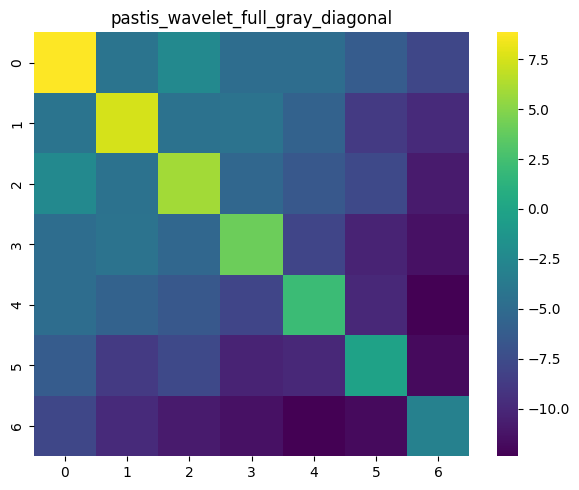

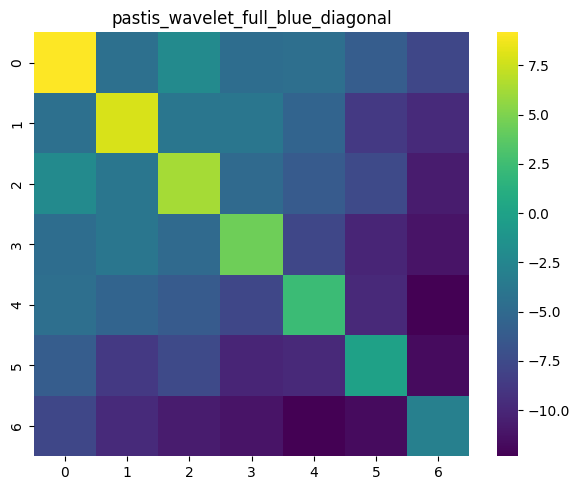

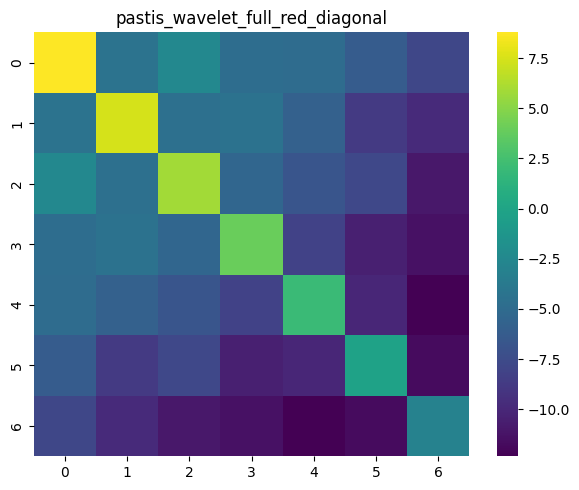

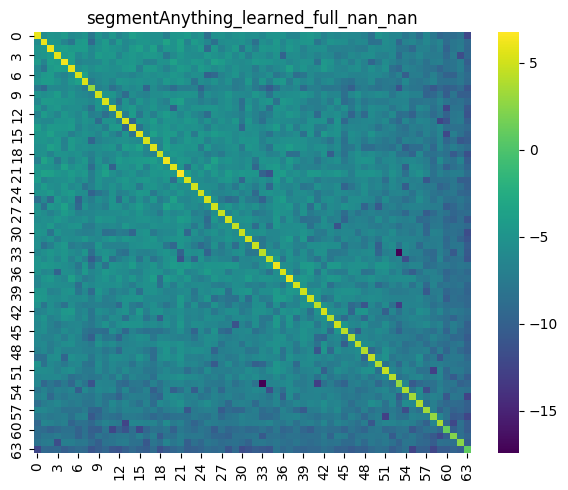

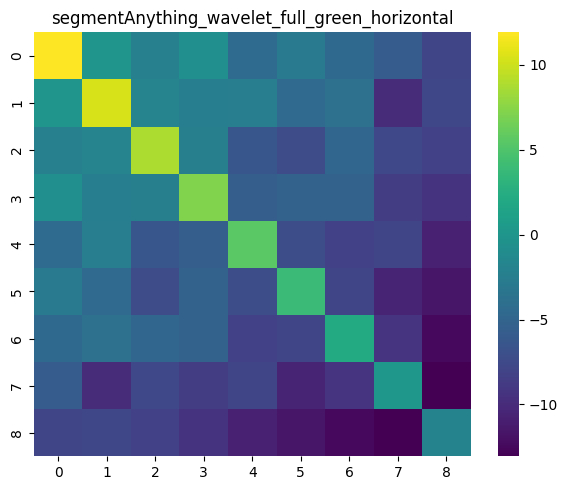

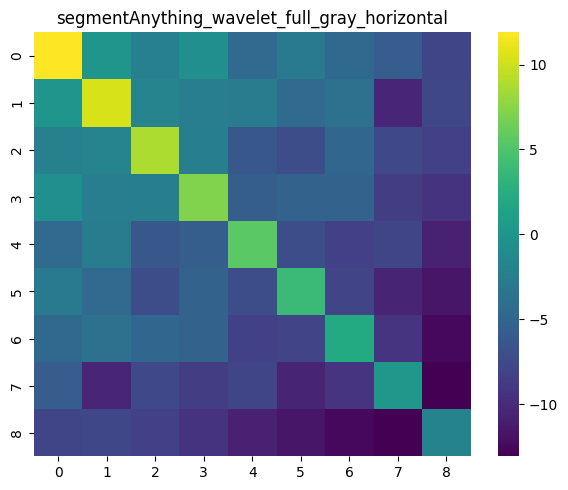

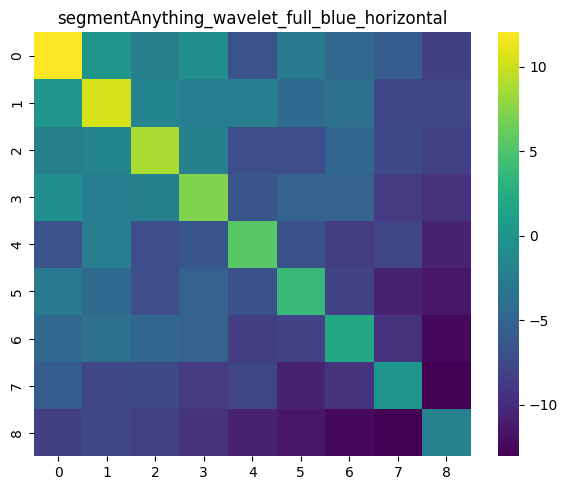

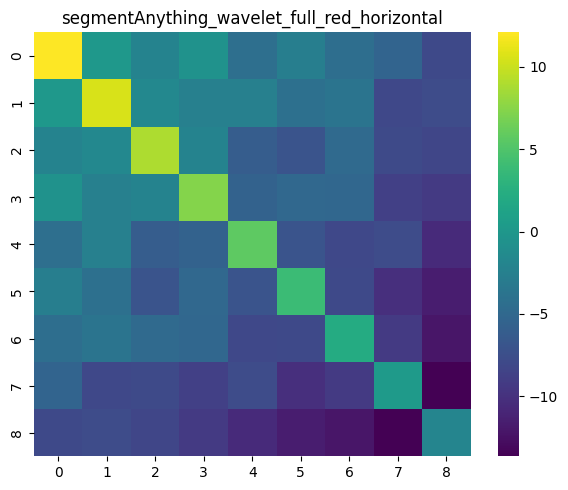

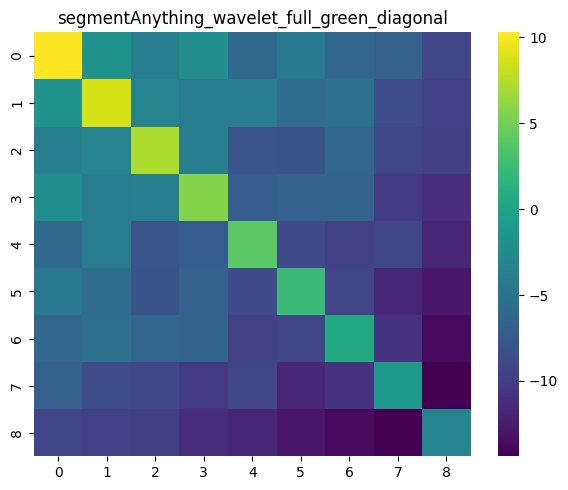

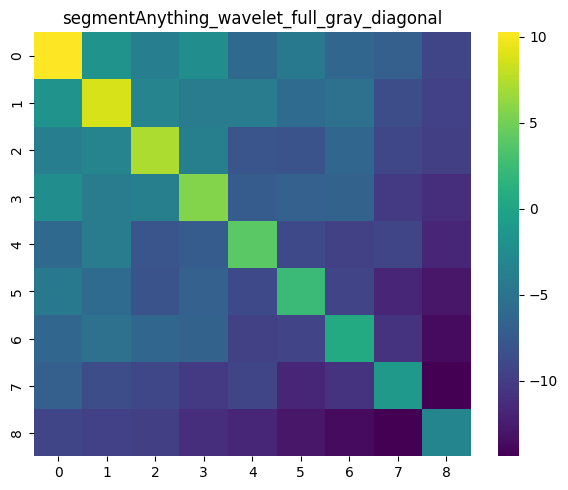

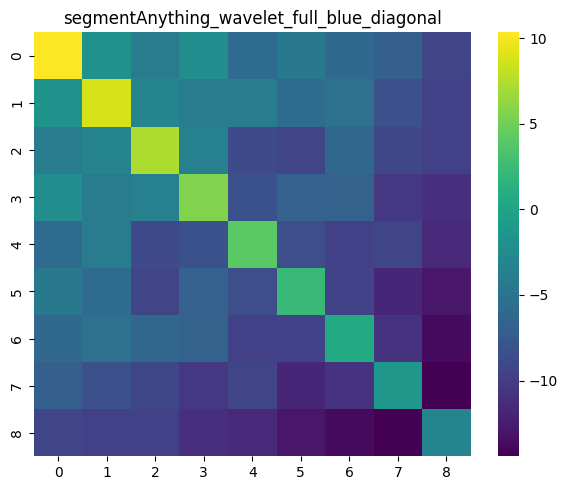

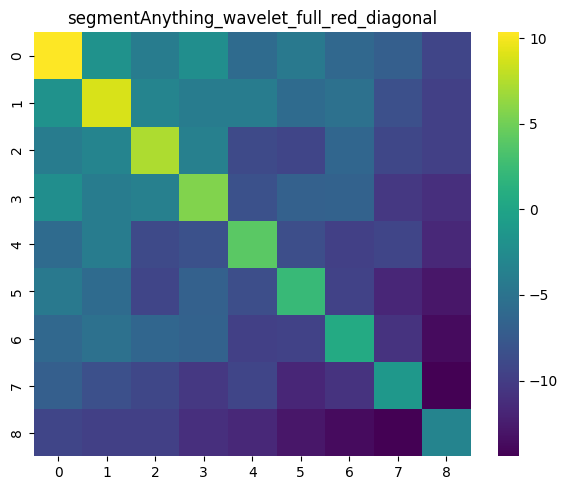

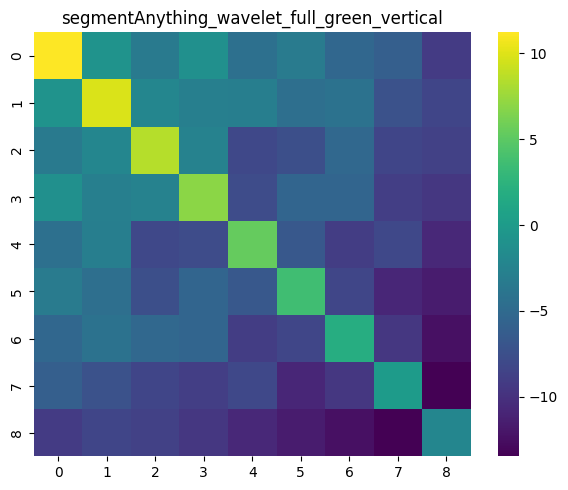

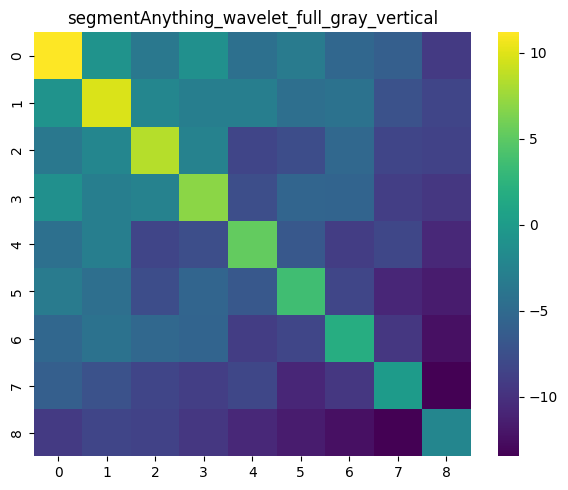

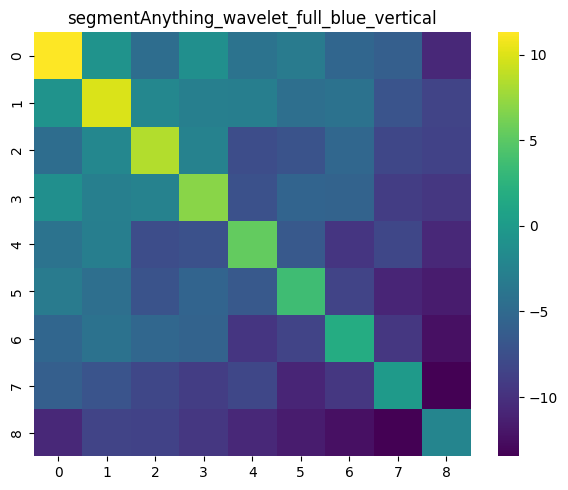

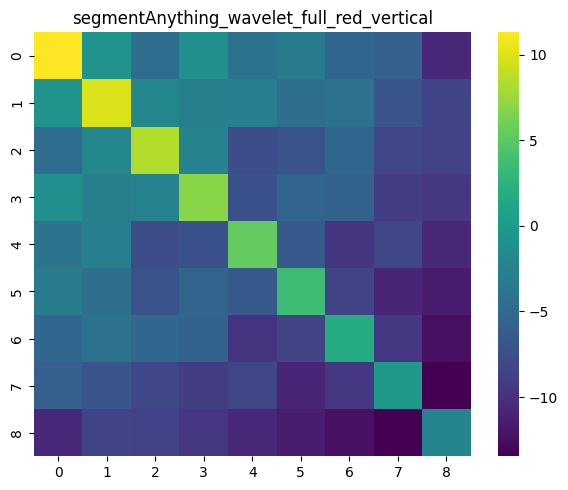

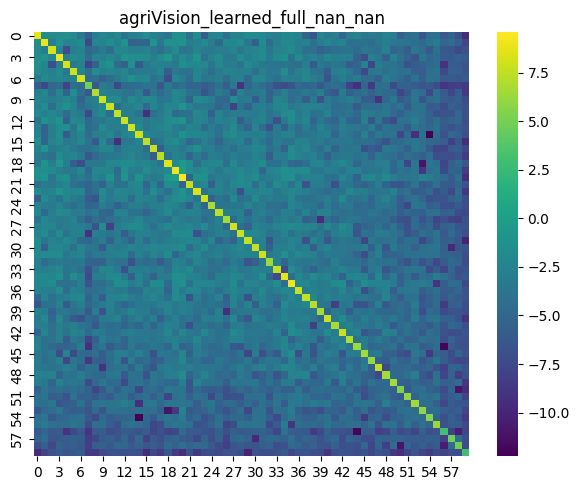

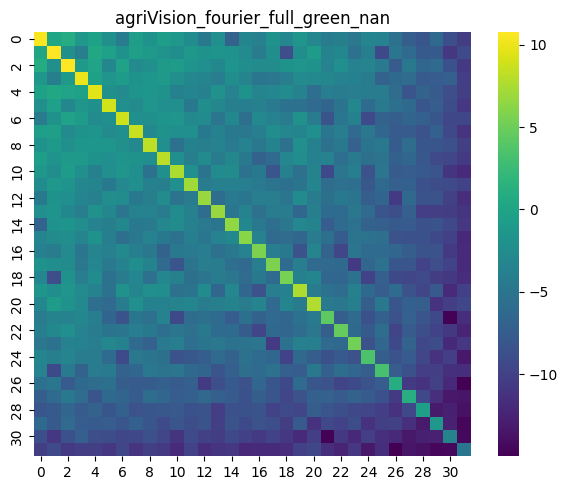

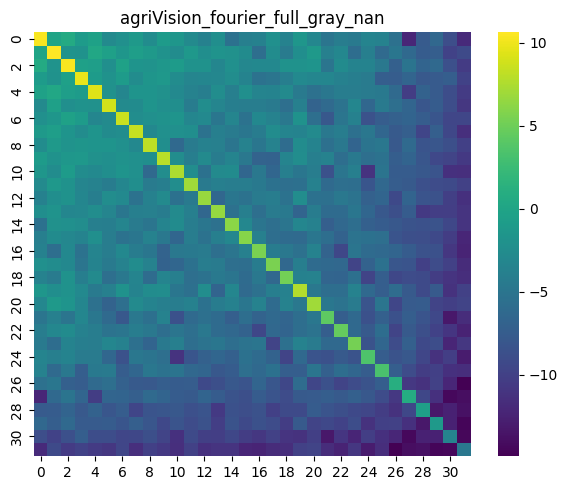

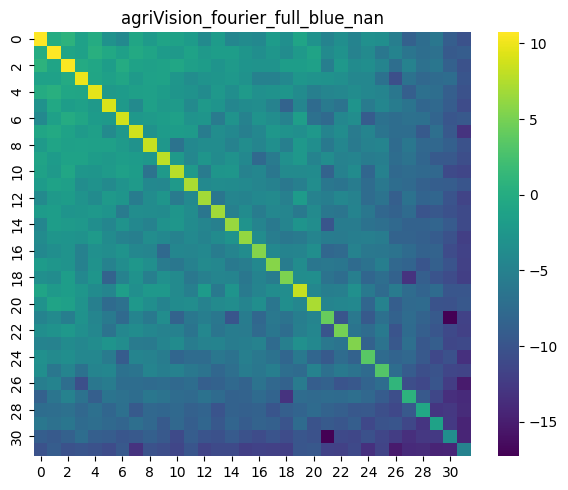

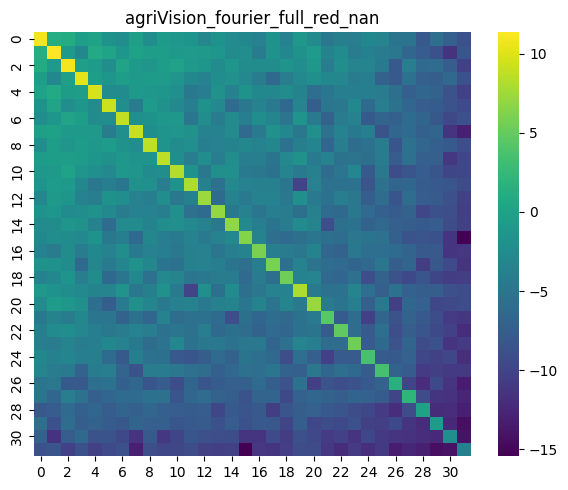

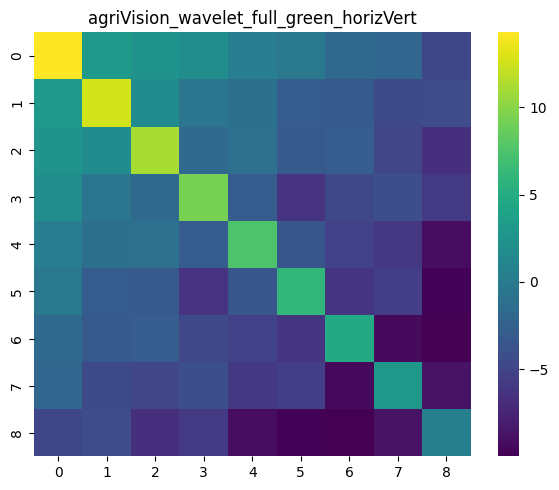

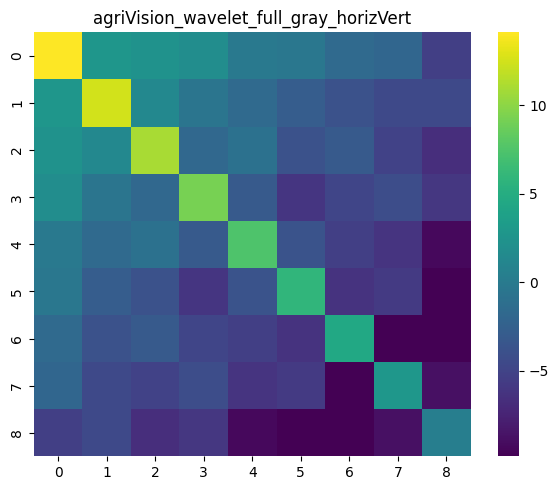

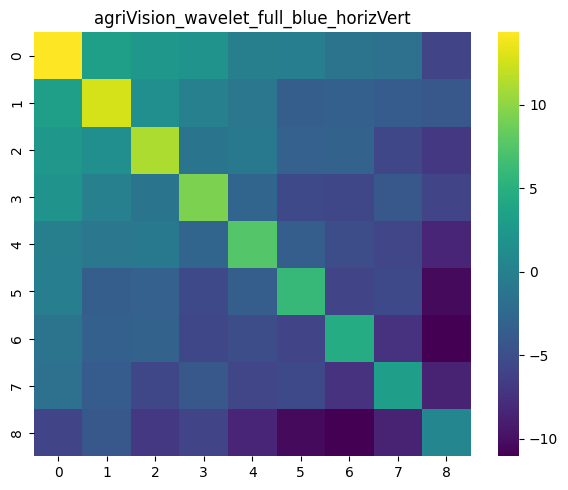

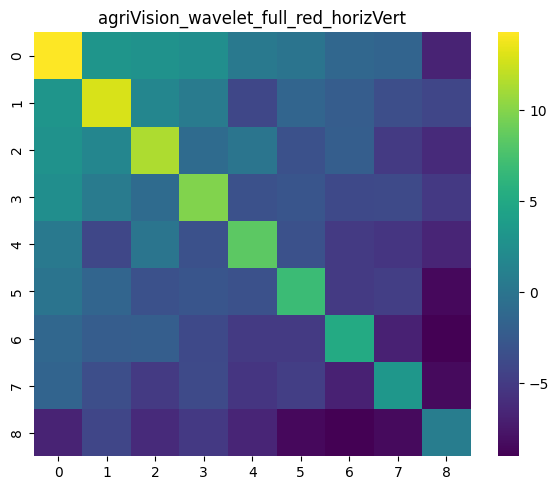

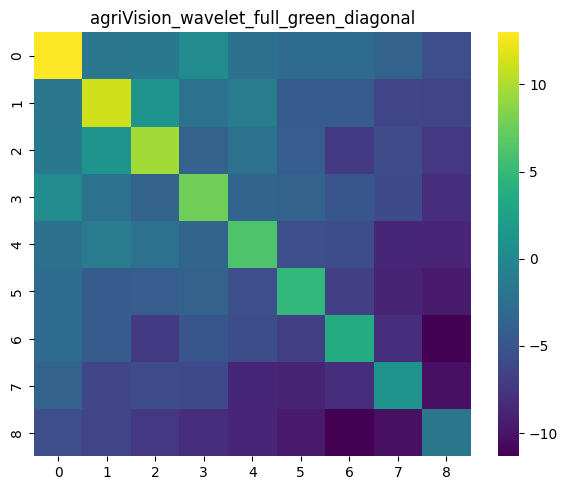

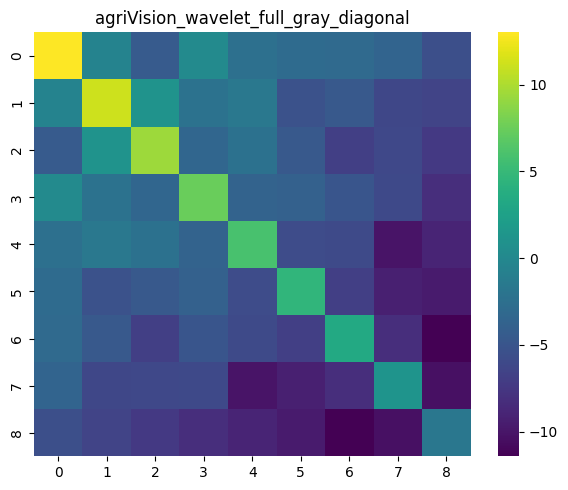

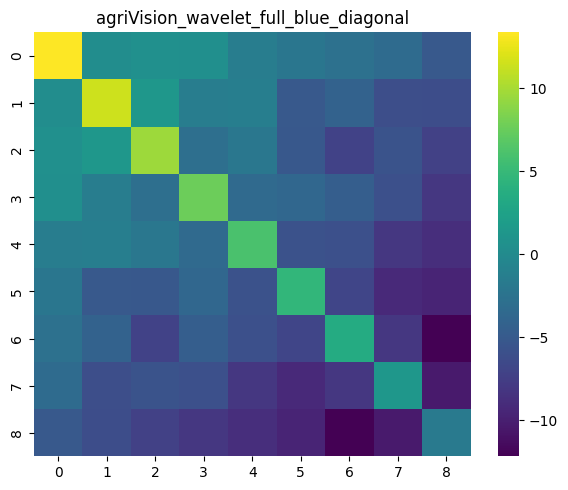

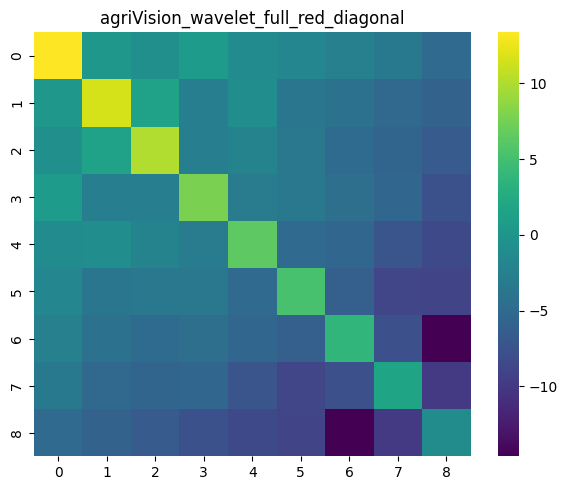

In [72]:
for idx, row in cov_main_df.iterrows():
    cov_matrix = np.array(row['cov_matrix'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(np.log(np.abs(cov_matrix) + 1e-12), cmap='viridis')
    plt.title(f"{row['dataset']}_{row['transform']}_{row['subset']}_{row['channel']}_{row['orientation']}")
    plt.tight_layout()
    #filename = f"{row['dataset']}_{row['transform']}_{row['subset']}_{row['channel']}_{row['orientation']}_cov_heatmap.png"
    #filename = filename.replace(' ', '_').replace('/', '_')
    #plt.savefig(filename)
    plt.show()
    plt.close()